In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
batch_size = 32
img_height = 224
img_width = 224

In [3]:
!ls -l ../../shared/fruit_veg

total 2
drwxrwxr-x. 38 david-mcmahon3 users 36 Mar 10 09:31 test
drwxrwxr-x. 38 david-mcmahon3 users 36 Mar 10 09:32 train
drwxrwxr-x. 38 david-mcmahon3 users 36 Mar 10 09:32 validation


In [4]:

# TRAIN_DIR =cwd+'/FruitRecognization/train/'  
# TEST_DIR =cwd+'/FruitRecognization/test/'
# VALID_DIR =cwd+'/FruitRecognization/validation/'
TEST_DIR = '../../shared/fruit_veg/test'
TRAIN_DIR ='../../shared/fruit_veg/train'
VALID_DIR ='../../shared/fruit_veg/validation'

In [5]:

train_ds = tf.keras.preprocessing.image_dataset_from_directory(TRAIN_DIR,
                                                               seed=2509,
                                                               image_size=(img_height, img_width),
                                                               batch_size=batch_size)

Found 3115 files belonging to 36 classes.


2023-03-21 08:55:14.048930: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: UNKNOWN ERROR (34)
2023-03-21 08:55:14.049003: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (notebook-test-0): /proc/driver/nvidia/version does not exist
2023-03-21 08:55:14.049370: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:

valid_ds = tf.keras.preprocessing.image_dataset_from_directory(VALID_DIR,
                                                               seed=2509,
                                                               image_size=(img_height, img_width),
                                                               shuffle=False,
                                                               batch_size=batch_size)

Found 351 files belonging to 36 classes.


In [7]:

test_ds = tf.keras.preprocessing.image_dataset_from_directory(TEST_DIR,
                                                              seed=2509,
                                                              image_size=(img_height, img_width),
                                                              shuffle=False,
                                                              batch_size=batch_size)
     

Found 359 files belonging to 36 classes.


In [8]:
class_names = train_ds.class_names
print(class_names)
     

['apple', 'banana', 'beetroot', 'bell pepper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon', 'lettuce', 'mango', 'onion', 'orange', 'paprika', 'pear', 'peas', 'pineapple', 'pomegranate', 'potato', 'raddish', 'soy beans', 'spinach', 'sweetcorn', 'sweetpotato', 'tomato', 'turnip', 'watermelon']


2023-03-21 08:55:23.207063: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 08:55:23.887017: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 08:55:24.373833: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...


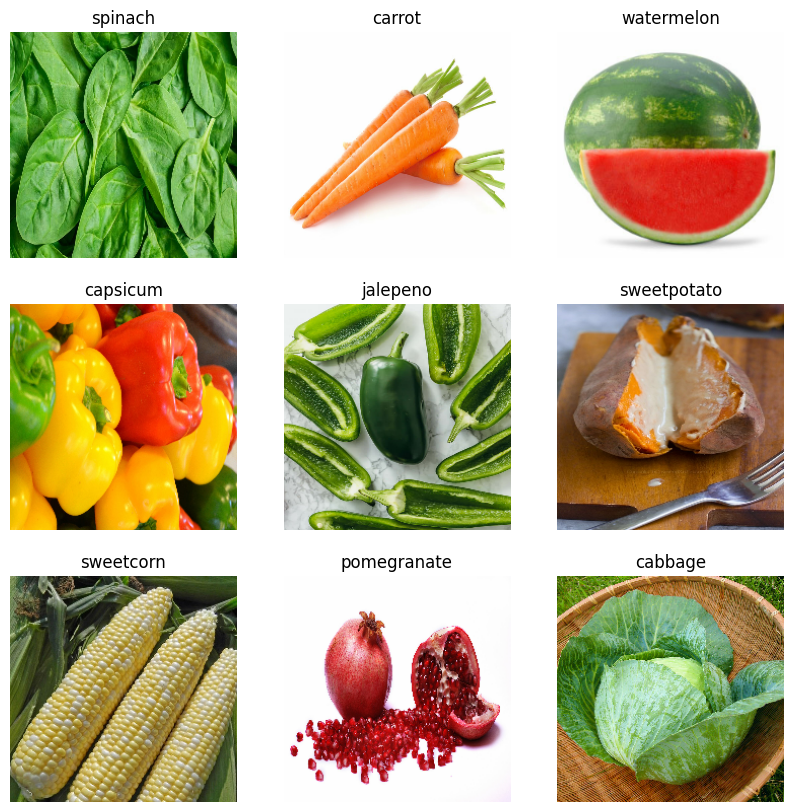

In [9]:

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [10]:

base_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [11]:
base_model.trainable = False

In [12]:

data_augmentation = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
])

In [13]:

inputs = tf.keras.Input(shape=(224,224,3))
x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)
x = data_augmentation(x)
x = base_model(x,training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024,activation='relu')(x)
x = tf.keras.layers.Dense(512,activation='relu')(x)
x = tf.keras.layers.Dense(len(class_names),activation='softmax')(x)

In [14]:
model = tf.keras.Model(inputs=inputs, outputs=x, name="flower_vegetable_Detection_MobileNetV2")

In [15]:
# Compile the model
model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(lr=0.001),
    metrics = ["accuracy"])

/opt/conda/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [16]:
model.summary()

Model: "flower_vegetable_Detection_MobileNetV2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)          

In [17]:
initial_epochs = 5

In [19]:
# Fit the model
history = model.fit(x=train_ds,
                    epochs= initial_epochs,
                    validation_data=valid_ds)

Epoch 1/5


2023-03-21 09:04:56.705014: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:04:57.344017: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:04:57.748033: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...


 2/98 [..............................] - ETA: 1:26 - loss: 0.3389 - accuracy: 0.9062

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:04:59.435217: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...


 3/98 [..............................] - ETA: 1:15 - loss: 0.5053 - accuracy: 0.8750

Cleanup called...
Cleanup called...
Cleanup called...


 4/98 [>.............................] - ETA: 1:09 - loss: 0.4307 - accuracy: 0.8906

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 5/98 [>.............................] - ETA: 1:05 - loss: 0.4468 - accuracy: 0.8687

Cleanup called...


 6/98 [>.............................] - ETA: 1:02 - loss: 0.4003 - accuracy: 0.8802

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 7/98 [=>............................] - ETA: 1:00 - loss: 0.3925 - accuracy: 0.8750

Cleanup called...
Cleanup called...


 9/98 [=>............................] - ETA: 57s - loss: 0.3933 - accuracy: 0.8715

Cleanup called...
Cleanup called...


10/98 [==>...........................] - ETA: 57s - loss: 0.3897 - accuracy: 0.8719

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:05:04.560572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-21 09:05:04.564051: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


11/98 [==>...........................] - ETA: 57s - loss: 0.3805 - accuracy: 0.8750

Cleanup called...
Cleanup called...


12/98 [==>...........................] - ETA: 55s - loss: 0.3885 - accuracy: 0.8750

Cleanup called...
Cleanup called...
Cleanup called...


13/98 [==>...........................] - ETA: 57s - loss: 0.3694 - accuracy: 0.8822

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


15/98 [===>..........................] - ETA: 54s - loss: 0.3836 - accuracy: 0.8750

Cleanup called...


16/98 [===>..........................] - ETA: 54s - loss: 0.3725 - accuracy: 0.8789

Cleanup called...
2023-03-21 09:05:08.342204: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...


17/98 [====>.........................] - ETA: 53s - loss: 0.3689 - accuracy: 0.8768

Cleanup called...
Cleanup called...
Cleanup called...


18/98 [====>.........................] - ETA: 52s - loss: 0.3723 - accuracy: 0.8750

Cleanup called...


19/98 [====>.........................] - ETA: 51s - loss: 0.3664 - accuracy: 0.8750

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


20/98 [=====>........................] - ETA: 50s - loss: 0.3662 - accuracy: 0.8750

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


22/98 [=====>........................] - ETA: 49s - loss: 0.3493 - accuracy: 0.8778

Cleanup called...


23/98 [======>.......................] - ETA: 48s - loss: 0.3521 - accuracy: 0.8777

Cleanup called...
Cleanup called...


24/98 [======>.......................] - ETA: 47s - loss: 0.3590 - accuracy: 0.8776

2023-03-21 09:05:13.050452: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...


25/98 [======>.......................] - ETA: 46s - loss: 0.3575 - accuracy: 0.8775

Cleanup called...
Cleanup called...


26/98 [======>.......................] - ETA: 45s - loss: 0.3598 - accuracy: 0.8774

Cleanup called...


27/98 [=======>......................] - ETA: 44s - loss: 0.3709 - accuracy: 0.8738

2023-03-21 09:05:14.835078: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...


29/98 [=======>......................] - ETA: 43s - loss: 0.3636 - accuracy: 0.8761

Cleanup called...
Cleanup called...
Cleanup called...


30/98 [========>.....................] - ETA: 42s - loss: 0.3648 - accuracy: 0.8760

2023-03-21 09:05:16.653149: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-21 09:05:16.656868: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...


31/98 [========>.....................] - ETA: 41s - loss: 0.3597 - accuracy: 0.8780

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


34/98 [=========>....................] - ETA: 39s - loss: 0.3551 - accuracy: 0.8778

Cleanup called...


35/98 [=========>....................] - ETA: 39s - loss: 0.3558 - accuracy: 0.8777

Cleanup called...


36/98 [==========>...................] - ETA: 38s - loss: 0.3601 - accuracy: 0.8767

Cleanup called...
Cleanup called...


37/98 [==========>...................] - ETA: 38s - loss: 0.3669 - accuracy: 0.8750

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


39/98 [==========>...................] - ETA: 36s - loss: 0.3672 - accuracy: 0.8742

Cleanup called...
Cleanup called...
Cleanup called...


40/98 [===========>..................] - ETA: 36s - loss: 0.3674 - accuracy: 0.8734

Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:05:23.066653: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...


42/98 [===========>..................] - ETA: 35s - loss: 0.3655 - accuracy: 0.8735

Cleanup called...
Cleanup called...
Cleanup called...


45/98 [============>.................] - ETA: 33s - loss: 0.3549 - accuracy: 0.8785

Cleanup called...


46/98 [=============>................] - ETA: 32s - loss: 0.3521 - accuracy: 0.8791

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:05:26.863704: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...


48/98 [=============>................] - ETA: 31s - loss: 0.3471 - accuracy: 0.8809

Cleanup called...
2023-03-21 09:05:27.948681: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...


50/98 [==============>...............] - ETA: 30s - loss: 0.3495 - accuracy: 0.8794

Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:05:29.260116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...


51/98 [==============>...............] - ETA: 29s - loss: 0.3519 - accuracy: 0.8793

Cleanup called...
Cleanup called...
Cleanup called...


52/98 [==============>...............] - ETA: 28s - loss: 0.3466 - accuracy: 0.8816

Cleanup called...


53/98 [===============>..............] - ETA: 28s - loss: 0.3504 - accuracy: 0.8803

Cleanup called...


54/98 [===============>..............] - ETA: 27s - loss: 0.3493 - accuracy: 0.8802

Cleanup called...
Cleanup called...
Cleanup called...


55/98 [===============>..............] - ETA: 26s - loss: 0.3480 - accuracy: 0.8801

Cleanup called...
Cleanup called...


56/98 [================>.............] - ETA: 26s - loss: 0.3517 - accuracy: 0.8789

Cleanup called...
Cleanup called...


57/98 [================>.............] - ETA: 25s - loss: 0.3512 - accuracy: 0.8788

Cleanup called...
Cleanup called...


58/98 [================>.............] - ETA: 24s - loss: 0.3559 - accuracy: 0.8772

2023-03-21 09:05:33.936256: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-21 09:05:33.937168: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...


59/98 [=================>............] - ETA: 24s - loss: 0.3541 - accuracy: 0.8782

Cleanup called...
Cleanup called...
Cleanup called...


60/98 [=================>............] - ETA: 23s - loss: 0.3529 - accuracy: 0.8781

Cleanup called...


62/98 [=================>............] - ETA: 22s - loss: 0.3516 - accuracy: 0.8780

Cleanup called...


63/98 [==================>...........] - ETA: 21s - loss: 0.3560 - accuracy: 0.8750

Cleanup called...


64/98 [==================>...........] - ETA: 21s - loss: 0.3563 - accuracy: 0.8750

Cleanup called...
Cleanup called...


68/98 [===================>..........] - ETA: 18s - loss: 0.3626 - accuracy: 0.8718

Cleanup called...
Cleanup called...


69/98 [====================>.........] - ETA: 17s - loss: 0.3600 - accuracy: 0.8727

Cleanup called...
Cleanup called...
Cleanup called...


70/98 [====================>.........] - ETA: 17s - loss: 0.3587 - accuracy: 0.8737

Cleanup called...
Cleanup called...
Cleanup called...


71/98 [====================>.........] - ETA: 16s - loss: 0.3580 - accuracy: 0.8737

Cleanup called...
Cleanup called...


73/98 [=====================>........] - ETA: 15s - loss: 0.3626 - accuracy: 0.8729

Cleanup called...
2023-03-21 09:05:43.136989: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...


74/98 [=====================>........] - ETA: 14s - loss: 0.3653 - accuracy: 0.8725

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:05:44.157644: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...


75/98 [=====================>........] - ETA: 14s - loss: 0.3637 - accuracy: 0.8733

Cleanup called...


76/98 [======================>.......] - ETA: 13s - loss: 0.3650 - accuracy: 0.8738

Cleanup called...
2023-03-21 09:05:45.137504: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


77/98 [======================>.......] - ETA: 13s - loss: 0.3691 - accuracy: 0.8726

Cleanup called...


78/98 [======================>.......] - ETA: 12s - loss: 0.3684 - accuracy: 0.8734

Cleanup called...


79/98 [=======================>......] - ETA: 11s - loss: 0.3661 - accuracy: 0.8742

Cleanup called...
Cleanup called...
Cleanup called...


80/98 [=======================>......] - ETA: 11s - loss: 0.3686 - accuracy: 0.8730

Cleanup called...
2023-03-21 09:05:48.057053: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...


81/98 [=======================>......] - ETA: 10s - loss: 0.3676 - accuracy: 0.8735

Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:05:48.536243: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...


82/98 [========================>.....] - ETA: 10s - loss: 0.3668 - accuracy: 0.8739

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


83/98 [========================>.....] - ETA: 9s - loss: 0.3669 - accuracy: 0.8735 

2023-03-21 09:05:49.460163: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...


98/98 [==============================] - ETA: 0s - loss: 0.3528 - accuracy: 0.8764

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:05:58.968466: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:05:59.956969: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...


98/98 [==============================] - 66s 667ms/step - loss: 0.3528 - accuracy: 0.8764 - val_loss: 0.2415 - val_accuracy: 0.9174
Epoch 2/5


2023-03-21 09:06:03.078601: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:06:03.743838: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:06:04.151148: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...


 2/98 [..............................] - ETA: 1:27 - loss: 0.3167 - accuracy: 0.9062

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 3/98 [..............................] - ETA: 1:16 - loss: 0.3498 - accuracy: 0.8958

2023-03-21 09:06:06.251899: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 4/98 [>.............................] - ETA: 1:12 - loss: 0.2948 - accuracy: 0.9062

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 5/98 [>.............................] - ETA: 1:05 - loss: 0.3263 - accuracy: 0.8875

Cleanup called...


 6/98 [>.............................] - ETA: 1:02 - loss: 0.3347 - accuracy: 0.8854

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 7/98 [=>............................] - ETA: 59s - loss: 0.3470 - accuracy: 0.8839 

Cleanup called...
Cleanup called...


 9/98 [=>............................] - ETA: 56s - loss: 0.3441 - accuracy: 0.8854

Cleanup called...
Cleanup called...


10/98 [==>...........................] - ETA: 56s - loss: 0.3327 - accuracy: 0.8875

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:06:10.860112: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-21 09:06:10.864475: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


11/98 [==>...........................] - ETA: 55s - loss: 0.3387 - accuracy: 0.8864

Cleanup called...
Cleanup called...


12/98 [==>...........................] - ETA: 54s - loss: 0.3379 - accuracy: 0.8854

Cleanup called...
Cleanup called...
Cleanup called...


13/98 [==>...........................] - ETA: 56s - loss: 0.3306 - accuracy: 0.8894

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


14/98 [===>..........................] - ETA: 55s - loss: 0.3367 - accuracy: 0.8862

Cleanup called...


15/98 [===>..........................] - ETA: 53s - loss: 0.3349 - accuracy: 0.8875

Cleanup called...


16/98 [===>..........................] - ETA: 53s - loss: 0.3214 - accuracy: 0.8926

2023-03-21 09:06:14.544170: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...


17/98 [====>.........................] - ETA: 52s - loss: 0.3164 - accuracy: 0.8952

Cleanup called...
Cleanup called...
Cleanup called...


18/98 [====>.........................] - ETA: 51s - loss: 0.3091 - accuracy: 0.8958

Cleanup called...


19/98 [====>.........................] - ETA: 50s - loss: 0.3115 - accuracy: 0.8980

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


20/98 [=====>........................] - ETA: 50s - loss: 0.3089 - accuracy: 0.8969

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


22/98 [=====>........................] - ETA: 48s - loss: 0.3111 - accuracy: 0.8963

Cleanup called...


23/98 [======>.......................] - ETA: 47s - loss: 0.3146 - accuracy: 0.8940

Cleanup called...
Cleanup called...


24/98 [======>.......................] - ETA: 46s - loss: 0.3137 - accuracy: 0.8945

2023-03-21 09:06:19.437970: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...


25/98 [======>.......................] - ETA: 46s - loss: 0.3130 - accuracy: 0.8950

Cleanup called...
Cleanup called...


26/98 [======>.......................] - ETA: 45s - loss: 0.3106 - accuracy: 0.8954

Cleanup called...


27/98 [=======>......................] - ETA: 44s - loss: 0.3126 - accuracy: 0.8935

2023-03-21 09:06:21.147152: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...


29/98 [=======>......................] - ETA: 42s - loss: 0.3151 - accuracy: 0.8933

Cleanup called...
Cleanup called...
Cleanup called...


30/98 [========>.....................] - ETA: 42s - loss: 0.3109 - accuracy: 0.8958

2023-03-21 09:06:22.849589: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-21 09:06:22.851743: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...


31/98 [========>.....................] - ETA: 41s - loss: 0.3106 - accuracy: 0.8952

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


34/98 [=========>....................] - ETA: 39s - loss: 0.3135 - accuracy: 0.8934

Cleanup called...


35/98 [=========>....................] - ETA: 38s - loss: 0.3089 - accuracy: 0.8938

Cleanup called...


36/98 [==========>...................] - ETA: 38s - loss: 0.3051 - accuracy: 0.8941

Cleanup called...
Cleanup called...


37/98 [==========>...................] - ETA: 37s - loss: 0.3048 - accuracy: 0.8953

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


39/98 [==========>...................] - ETA: 36s - loss: 0.3024 - accuracy: 0.8966

Cleanup called...
Cleanup called...
Cleanup called...


40/98 [===========>..................] - ETA: 35s - loss: 0.3002 - accuracy: 0.8969

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:06:29.159924: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...


41/98 [===========>..................] - ETA: 35s - loss: 0.3019 - accuracy: 0.8956

Cleanup called...


42/98 [===========>..................] - ETA: 34s - loss: 0.3031 - accuracy: 0.8951

Cleanup called...
Cleanup called...
Cleanup called...


45/98 [============>.................] - ETA: 32s - loss: 0.2974 - accuracy: 0.8951

Cleanup called...


47/98 [=============>................] - ETA: 31s - loss: 0.3038 - accuracy: 0.8943

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:06:33.437094: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...


48/98 [=============>................] - ETA: 30s - loss: 0.3023 - accuracy: 0.8945

2023-03-21 09:06:34.340850: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...


49/98 [==============>...............] - ETA: 30s - loss: 0.3021 - accuracy: 0.8941

Cleanup called...
Cleanup called...


50/98 [==============>...............] - ETA: 29s - loss: 0.3025 - accuracy: 0.8938

Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:06:35.551289: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...


51/98 [==============>...............] - ETA: 29s - loss: 0.3031 - accuracy: 0.8928

Cleanup called...
Cleanup called...
Cleanup called...


52/98 [==============>...............] - ETA: 28s - loss: 0.3015 - accuracy: 0.8930

Cleanup called...


53/98 [===============>..............] - ETA: 27s - loss: 0.2985 - accuracy: 0.8950

Cleanup called...


54/98 [===============>..............] - ETA: 27s - loss: 0.3006 - accuracy: 0.8929

Cleanup called...
Cleanup called...
Cleanup called...


55/98 [===============>..............] - ETA: 26s - loss: 0.3035 - accuracy: 0.8920

Cleanup called...
Cleanup called...


56/98 [================>.............] - ETA: 25s - loss: 0.3012 - accuracy: 0.8929

Cleanup called...
Cleanup called...


57/98 [================>.............] - ETA: 25s - loss: 0.3026 - accuracy: 0.8925

Cleanup called...


58/98 [================>.............] - ETA: 24s - loss: 0.2991 - accuracy: 0.8944

Cleanup called...
2023-03-21 09:06:39.767374: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-21 09:06:39.838041: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...


59/98 [=================>............] - ETA: 23s - loss: 0.2999 - accuracy: 0.8951

Cleanup called...
Cleanup called...
Cleanup called...


60/98 [=================>............] - ETA: 23s - loss: 0.3019 - accuracy: 0.8938

Cleanup called...


62/98 [=================>............] - ETA: 22s - loss: 0.3034 - accuracy: 0.8916

Cleanup called...


63/98 [==================>...........] - ETA: 21s - loss: 0.3022 - accuracy: 0.8929

Cleanup called...


64/98 [==================>...........] - ETA: 20s - loss: 0.3022 - accuracy: 0.8936

Cleanup called...
Cleanup called...


68/98 [===================>..........] - ETA: 18s - loss: 0.3042 - accuracy: 0.8929

Cleanup called...
Cleanup called...


69/98 [====================>.........] - ETA: 17s - loss: 0.3024 - accuracy: 0.8936

Cleanup called...
Cleanup called...
Cleanup called...


70/98 [====================>.........] - ETA: 16s - loss: 0.3002 - accuracy: 0.8942

Cleanup called...
Cleanup called...
Cleanup called...


71/98 [====================>.........] - ETA: 16s - loss: 0.2988 - accuracy: 0.8944

Cleanup called...
Cleanup called...


73/98 [=====================>........] - ETA: 15s - loss: 0.3043 - accuracy: 0.8934

Cleanup called...
2023-03-21 09:06:48.530657: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...


74/98 [=====================>........] - ETA: 14s - loss: 0.3012 - accuracy: 0.8948

Cleanup called...
Cleanup called...


75/98 [=====================>........] - ETA: 13s - loss: 0.3020 - accuracy: 0.8942

Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:06:49.937656: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...


76/98 [======================>.......] - ETA: 13s - loss: 0.3020 - accuracy: 0.8935

Cleanup called...
2023-03-21 09:06:50.736739: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


77/98 [======================>.......] - ETA: 12s - loss: 0.3058 - accuracy: 0.8925

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


78/98 [======================>.......] - ETA: 12s - loss: 0.3043 - accuracy: 0.8930

Cleanup called...


79/98 [=======================>......] - ETA: 11s - loss: 0.3087 - accuracy: 0.8908

Cleanup called...


80/98 [=======================>......] - ETA: 10s - loss: 0.3095 - accuracy: 0.8898

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


81/98 [=======================>......] - ETA: 10s - loss: 0.3087 - accuracy: 0.8900

2023-03-21 09:06:53.636089: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...


82/98 [========================>.....] - ETA: 9s - loss: 0.3083 - accuracy: 0.8899 

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:06:54.139499: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


83/98 [========================>.....] - ETA: 9s - loss: 0.3073 - accuracy: 0.8901

2023-03-21 09:06:54.836062: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


84/98 [========================>.....] - ETA: 8s - loss: 0.3120 - accuracy: 0.8891

Cleanup called...


98/98 [==============================] - ETA: 0s - loss: 0.3097 - accuracy: 0.8899

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:07:04.071624: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:07:04.841869: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...


98/98 [==============================] - 65s 650ms/step - loss: 0.3097 - accuracy: 0.8899 - val_loss: 0.3319 - val_accuracy: 0.8946
Epoch 3/5


2023-03-21 09:07:07.877436: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:07:08.525464: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:07:08.894321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...


 2/98 [..............................] - ETA: 58s - loss: 0.4788 - accuracy: 0.8594 

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 3/98 [..............................] - ETA: 57s - loss: 0.4151 - accuracy: 0.8750

2023-03-21 09:07:10.740454: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 4/98 [>.............................] - ETA: 59s - loss: 0.3995 - accuracy: 0.8672

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 5/98 [>.............................] - ETA: 56s - loss: 0.4455 - accuracy: 0.8625

Cleanup called...


 6/98 [>.............................] - ETA: 55s - loss: 0.4474 - accuracy: 0.8542

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 7/98 [=>............................] - ETA: 53s - loss: 0.4132 - accuracy: 0.8616

Cleanup called...
Cleanup called...


 9/98 [=>............................] - ETA: 52s - loss: 0.3725 - accuracy: 0.8715

Cleanup called...
Cleanup called...


10/98 [==>...........................] - ETA: 52s - loss: 0.3524 - accuracy: 0.8781

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:07:15.340974: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
2023-03-21 09:07:15.343033: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


12/98 [==>...........................] - ETA: 50s - loss: 0.3496 - accuracy: 0.8802

Cleanup called...
Cleanup called...
Cleanup called...


13/98 [==>...........................] - ETA: 52s - loss: 0.3466 - accuracy: 0.8798

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


14/98 [===>..........................] - ETA: 51s - loss: 0.3313 - accuracy: 0.8884

Cleanup called...


15/98 [===>..........................] - ETA: 50s - loss: 0.3283 - accuracy: 0.8896

Cleanup called...


16/98 [===>..........................] - ETA: 49s - loss: 0.3342 - accuracy: 0.8887

2023-03-21 09:07:18.742700: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...


17/98 [====>.........................] - ETA: 49s - loss: 0.3325 - accuracy: 0.8860

Cleanup called...
Cleanup called...


18/98 [====>.........................] - ETA: 48s - loss: 0.3551 - accuracy: 0.8854

Cleanup called...
Cleanup called...


19/98 [====>.........................] - ETA: 48s - loss: 0.3597 - accuracy: 0.8816

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


20/98 [=====>........................] - ETA: 47s - loss: 0.3476 - accuracy: 0.8844

Cleanup called...
Cleanup called...
Cleanup called...


21/98 [=====>........................] - ETA: 46s - loss: 0.3387 - accuracy: 0.8869

Cleanup called...


22/98 [=====>........................] - ETA: 45s - loss: 0.3349 - accuracy: 0.8878

Cleanup called...


23/98 [======>.......................] - ETA: 45s - loss: 0.3392 - accuracy: 0.8845

Cleanup called...
Cleanup called...


24/98 [======>.......................] - ETA: 44s - loss: 0.3383 - accuracy: 0.8828

2023-03-21 09:07:23.546056: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...


26/98 [======>.......................] - ETA: 42s - loss: 0.3469 - accuracy: 0.8774

Cleanup called...
Cleanup called...
Cleanup called...


27/98 [=======>......................] - ETA: 42s - loss: 0.3439 - accuracy: 0.8796

2023-03-21 09:07:25.156873: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...


29/98 [=======>......................] - ETA: 40s - loss: 0.3443 - accuracy: 0.8804

Cleanup called...
Cleanup called...
Cleanup called...


30/98 [========>.....................] - ETA: 40s - loss: 0.3399 - accuracy: 0.8802

2023-03-21 09:07:26.858114: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
2023-03-21 09:07:26.946154: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...


31/98 [========>.....................] - ETA: 39s - loss: 0.3348 - accuracy: 0.8810

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


34/98 [=========>....................] - ETA: 37s - loss: 0.3333 - accuracy: 0.8824

Cleanup called...


35/98 [=========>....................] - ETA: 37s - loss: 0.3342 - accuracy: 0.8830

Cleanup called...
Cleanup called...


36/98 [==========>...................] - ETA: 36s - loss: 0.3330 - accuracy: 0.8854

Cleanup called...


37/98 [==========>...................] - ETA: 36s - loss: 0.3328 - accuracy: 0.8851

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


39/98 [==========>...................] - ETA: 34s - loss: 0.3285 - accuracy: 0.8878

Cleanup called...
Cleanup called...
Cleanup called...


40/98 [===========>..................] - ETA: 34s - loss: 0.3265 - accuracy: 0.8883

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:07:32.944059: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...


41/98 [===========>..................] - ETA: 33s - loss: 0.3293 - accuracy: 0.8880

Cleanup called...
Cleanup called...
Cleanup called...


45/98 [============>.................] - ETA: 31s - loss: 0.3235 - accuracy: 0.8903

Cleanup called...


46/98 [=============>................] - ETA: 30s - loss: 0.3218 - accuracy: 0.8913

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:07:36.780171: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...


48/98 [=============>................] - ETA: 29s - loss: 0.3225 - accuracy: 0.8900

2023-03-21 09:07:37.749005: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


50/98 [==============>...............] - ETA: 28s - loss: 0.3300 - accuracy: 0.8881

Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:07:39.145260: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...


51/98 [==============>...............] - ETA: 28s - loss: 0.3293 - accuracy: 0.8885

Cleanup called...
Cleanup called...
Cleanup called...


52/98 [==============>...............] - ETA: 27s - loss: 0.3259 - accuracy: 0.8900

Cleanup called...


53/98 [===============>..............] - ETA: 26s - loss: 0.3241 - accuracy: 0.8903

Cleanup called...


54/98 [===============>..............] - ETA: 26s - loss: 0.3222 - accuracy: 0.8906

Cleanup called...
Cleanup called...
Cleanup called...


55/98 [===============>..............] - ETA: 25s - loss: 0.3235 - accuracy: 0.8903

Cleanup called...
Cleanup called...


56/98 [================>.............] - ETA: 24s - loss: 0.3229 - accuracy: 0.8901

Cleanup called...
Cleanup called...


57/98 [================>.............] - ETA: 24s - loss: 0.3214 - accuracy: 0.8909

Cleanup called...
Cleanup called...


58/98 [================>.............] - ETA: 23s - loss: 0.3188 - accuracy: 0.8917

2023-03-21 09:07:43.460400: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-21 09:07:43.541056: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...


59/98 [=================>............] - ETA: 23s - loss: 0.3197 - accuracy: 0.8909

Cleanup called...
Cleanup called...
Cleanup called...


60/98 [=================>............] - ETA: 22s - loss: 0.3160 - accuracy: 0.8927

Cleanup called...


62/98 [=================>............] - ETA: 21s - loss: 0.3144 - accuracy: 0.8921

Cleanup called...


63/98 [==================>...........] - ETA: 20s - loss: 0.3139 - accuracy: 0.8919

Cleanup called...


64/98 [==================>...........] - ETA: 20s - loss: 0.3125 - accuracy: 0.8921

Cleanup called...
Cleanup called...


67/98 [===================>..........] - ETA: 18s - loss: 0.3141 - accuracy: 0.8918

Cleanup called...
Cleanup called...


69/98 [====================>.........] - ETA: 17s - loss: 0.3104 - accuracy: 0.8936

Cleanup called...
Cleanup called...
Cleanup called...


70/98 [====================>.........] - ETA: 16s - loss: 0.3108 - accuracy: 0.8929

Cleanup called...
Cleanup called...
Cleanup called...


71/98 [====================>.........] - ETA: 15s - loss: 0.3089 - accuracy: 0.8930

Cleanup called...
Cleanup called...


73/98 [=====================>........] - ETA: 14s - loss: 0.3079 - accuracy: 0.8930

Cleanup called...
2023-03-21 09:07:52.417116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...


74/98 [=====================>........] - ETA: 14s - loss: 0.3073 - accuracy: 0.8936

Cleanup called...
Cleanup called...


75/98 [=====================>........] - ETA: 13s - loss: 0.3072 - accuracy: 0.8929

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:07:53.935097: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...


76/98 [======================>.......] - ETA: 13s - loss: 0.3075 - accuracy: 0.8931

Cleanup called...
Cleanup called...
2023-03-21 09:07:54.738670: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...


77/98 [======================>.......] - ETA: 12s - loss: 0.3120 - accuracy: 0.8925

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


78/98 [======================>.......] - ETA: 11s - loss: 0.3139 - accuracy: 0.8918

Cleanup called...


80/98 [=======================>......] - ETA: 10s - loss: 0.3163 - accuracy: 0.8906

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


82/98 [========================>.....] - ETA: 9s - loss: 0.3162 - accuracy: 0.8902 

2023-03-21 09:07:57.750632: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:07:58.349286: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...


83/98 [========================>.....] - ETA: 8s - loss: 0.3158 - accuracy: 0.8904

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


84/98 [========================>.....] - ETA: 8s - loss: 0.3159 - accuracy: 0.8899

2023-03-21 09:07:59.136128: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...


98/98 [==============================] - ETA: 0s - loss: 0.3125 - accuracy: 0.8909

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:08:07.767490: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:08:08.648666: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...


98/98 [==============================] - 64s 638ms/step - loss: 0.3125 - accuracy: 0.8909 - val_loss: 0.2767 - val_accuracy: 0.9174
Epoch 4/5


2023-03-21 09:08:11.669493: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:08:12.265127: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:08:12.744817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...


 2/98 [..............................] - ETA: 1:25 - loss: 0.2405 - accuracy: 0.9219

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 3/98 [..............................] - ETA: 1:11 - loss: 0.2756 - accuracy: 0.8958

Cleanup called...
2023-03-21 09:08:14.948635: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...


 4/98 [>.............................] - ETA: 1:05 - loss: 0.2814 - accuracy: 0.8828

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 5/98 [>.............................] - ETA: 1:02 - loss: 0.2718 - accuracy: 0.8813

Cleanup called...
Cleanup called...


 6/98 [>.............................] - ETA: 1:00 - loss: 0.3223 - accuracy: 0.8802

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 7/98 [=>............................] - ETA: 59s - loss: 0.3244 - accuracy: 0.8750 

Cleanup called...
Cleanup called...


 9/98 [=>............................] - ETA: 56s - loss: 0.2814 - accuracy: 0.8958

Cleanup called...
Cleanup called...


10/98 [==>...........................] - ETA: 55s - loss: 0.2798 - accuracy: 0.8938

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:08:19.362643: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:08:19.435216: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...


11/98 [==>...........................] - ETA: 55s - loss: 0.2715 - accuracy: 0.8949

Cleanup called...
Cleanup called...


12/98 [==>...........................] - ETA: 53s - loss: 0.2691 - accuracy: 0.8958

Cleanup called...
Cleanup called...
Cleanup called...


13/98 [==>...........................] - ETA: 55s - loss: 0.2775 - accuracy: 0.8942

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


15/98 [===>..........................] - ETA: 53s - loss: 0.2775 - accuracy: 0.8938

Cleanup called...


16/98 [===>..........................] - ETA: 51s - loss: 0.2734 - accuracy: 0.8945

Cleanup called...
Cleanup called...
2023-03-21 09:08:23.037094: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...


17/98 [====>.........................] - ETA: 51s - loss: 0.2714 - accuracy: 0.8934

Cleanup called...
Cleanup called...


18/98 [====>.........................] - ETA: 50s - loss: 0.2650 - accuracy: 0.8958

Cleanup called...
Cleanup called...


19/98 [====>.........................] - ETA: 50s - loss: 0.2654 - accuracy: 0.8964

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


20/98 [=====>........................] - ETA: 49s - loss: 0.2579 - accuracy: 0.9000

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


22/98 [=====>........................] - ETA: 47s - loss: 0.2594 - accuracy: 0.9034

Cleanup called...


23/98 [======>.......................] - ETA: 46s - loss: 0.2545 - accuracy: 0.9035

Cleanup called...
Cleanup called...


24/98 [======>.......................] - ETA: 46s - loss: 0.2574 - accuracy: 0.9010

2023-03-21 09:08:27.835044: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...


26/98 [======>.......................] - ETA: 44s - loss: 0.2606 - accuracy: 0.8978

Cleanup called...
Cleanup called...
Cleanup called...


27/98 [=======>......................] - ETA: 43s - loss: 0.2544 - accuracy: 0.9005

2023-03-21 09:08:29.437063: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...


29/98 [=======>......................] - ETA: 42s - loss: 0.2560 - accuracy: 0.9030

Cleanup called...
Cleanup called...
Cleanup called...


30/98 [========>.....................] - ETA: 41s - loss: 0.2656 - accuracy: 0.9000

2023-03-21 09:08:31.146305: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
2023-03-21 09:08:31.151053: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...


31/98 [========>.....................] - ETA: 40s - loss: 0.2693 - accuracy: 0.8972

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


34/98 [=========>....................] - ETA: 38s - loss: 0.2714 - accuracy: 0.8952

Cleanup called...


35/98 [=========>....................] - ETA: 38s - loss: 0.2692 - accuracy: 0.8964

Cleanup called...


36/98 [==========>...................] - ETA: 38s - loss: 0.2732 - accuracy: 0.8950

Cleanup called...
Cleanup called...


37/98 [==========>...................] - ETA: 37s - loss: 0.2773 - accuracy: 0.8927

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


39/98 [==========>...................] - ETA: 36s - loss: 0.2719 - accuracy: 0.8934

Cleanup called...
Cleanup called...
Cleanup called...


40/98 [===========>..................] - ETA: 35s - loss: 0.2741 - accuracy: 0.8914

Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:08:37.572000: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...


41/98 [===========>..................] - ETA: 35s - loss: 0.2716 - accuracy: 0.8918

Cleanup called...
Cleanup called...
Cleanup called...


45/98 [============>.................] - ETA: 32s - loss: 0.2743 - accuracy: 0.8931

Cleanup called...


46/98 [=============>................] - ETA: 32s - loss: 0.2759 - accuracy: 0.8947

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:08:41.363561: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...


48/98 [=============>................] - ETA: 30s - loss: 0.2779 - accuracy: 0.8952

Cleanup called...
2023-03-21 09:08:42.536003: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...


50/98 [==============>...............] - ETA: 29s - loss: 0.2795 - accuracy: 0.8950

Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:08:43.943608: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...


51/98 [==============>...............] - ETA: 29s - loss: 0.2783 - accuracy: 0.8958

Cleanup called...
Cleanup called...


52/98 [==============>...............] - ETA: 28s - loss: 0.2822 - accuracy: 0.8948

Cleanup called...
Cleanup called...


53/98 [===============>..............] - ETA: 27s - loss: 0.2860 - accuracy: 0.8933

Cleanup called...


54/98 [===============>..............] - ETA: 27s - loss: 0.2839 - accuracy: 0.8941

Cleanup called...
Cleanup called...
Cleanup called...


55/98 [===============>..............] - ETA: 26s - loss: 0.2841 - accuracy: 0.8943

Cleanup called...
Cleanup called...


56/98 [================>.............] - ETA: 25s - loss: 0.2854 - accuracy: 0.8940

Cleanup called...
Cleanup called...


57/98 [================>.............] - ETA: 25s - loss: 0.2872 - accuracy: 0.8936

Cleanup called...
Cleanup called...


58/98 [================>.............] - ETA: 24s - loss: 0.2855 - accuracy: 0.8939

2023-03-21 09:08:48.360393: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-21 09:08:48.439364: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...


59/98 [=================>............] - ETA: 23s - loss: 0.2838 - accuracy: 0.8946

Cleanup called...
Cleanup called...
Cleanup called...


60/98 [=================>............] - ETA: 23s - loss: 0.2853 - accuracy: 0.8943

Cleanup called...


62/98 [=================>............] - ETA: 22s - loss: 0.2842 - accuracy: 0.8942

Cleanup called...


63/98 [==================>...........] - ETA: 21s - loss: 0.2815 - accuracy: 0.8953

Cleanup called...


64/98 [==================>...........] - ETA: 20s - loss: 0.2808 - accuracy: 0.8950

Cleanup called...
Cleanup called...


67/98 [===================>..........] - ETA: 18s - loss: 0.2791 - accuracy: 0.8955

Cleanup called...
Cleanup called...


69/98 [====================>.........] - ETA: 17s - loss: 0.2809 - accuracy: 0.8949

Cleanup called...
Cleanup called...
Cleanup called...


70/98 [====================>.........] - ETA: 17s - loss: 0.2791 - accuracy: 0.8951

Cleanup called...
Cleanup called...
Cleanup called...


71/98 [====================>.........] - ETA: 16s - loss: 0.2772 - accuracy: 0.8957

Cleanup called...
Cleanup called...


73/98 [=====================>........] - ETA: 15s - loss: 0.2731 - accuracy: 0.8968

Cleanup called...
2023-03-21 09:08:57.260839: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...


75/98 [=====================>........] - ETA: 14s - loss: 0.2740 - accuracy: 0.8971

Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:08:58.842879: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...


76/98 [======================>.......] - ETA: 13s - loss: 0.2741 - accuracy: 0.8968

Cleanup called...
Cleanup called...
Cleanup called...


77/98 [======================>.......] - ETA: 12s - loss: 0.2736 - accuracy: 0.8973

Cleanup called...
2023-03-21 09:08:59.750098: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


78/98 [======================>.......] - ETA: 12s - loss: 0.2719 - accuracy: 0.8982

Cleanup called...


79/98 [=======================>......] - ETA: 11s - loss: 0.2736 - accuracy: 0.8979

Cleanup called...


80/98 [=======================>......] - ETA: 11s - loss: 0.2729 - accuracy: 0.8980

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:09:02.277820: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...


81/98 [=======================>......] - ETA: 10s - loss: 0.2733 - accuracy: 0.8981

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:09:02.843325: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...


82/98 [========================>.....] - ETA: 9s - loss: 0.2747 - accuracy: 0.8975 

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:09:03.642654: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


83/98 [========================>.....] - ETA: 9s - loss: 0.2725 - accuracy: 0.8980

Cleanup called...


98/98 [==============================] - ETA: 0s - loss: 0.2648 - accuracy: 0.9014

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:09:12.947135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:09:13.841623: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...


98/98 [==============================] - 65s 655ms/step - loss: 0.2648 - accuracy: 0.9014 - val_loss: 0.2596 - val_accuracy: 0.9117
Epoch 5/5


2023-03-21 09:09:16.888217: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:09:17.561971: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:09:17.983340: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...


 2/98 [..............................] - ETA: 1:26 - loss: 0.3815 - accuracy: 0.8438

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 3/98 [..............................] - ETA: 1:11 - loss: 0.3755 - accuracy: 0.8438

2023-03-21 09:09:20.039560: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 4/98 [>.............................] - ETA: 1:09 - loss: 0.3226 - accuracy: 0.8672

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 5/98 [>.............................] - ETA: 1:05 - loss: 0.3179 - accuracy: 0.8687

Cleanup called...


 6/98 [>.............................] - ETA: 1:01 - loss: 0.3094 - accuracy: 0.8750

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 7/98 [=>............................] - ETA: 59s - loss: 0.2791 - accuracy: 0.8929 

Cleanup called...
Cleanup called...


 9/98 [=>............................] - ETA: 55s - loss: 0.2529 - accuracy: 0.8993

Cleanup called...
Cleanup called...


10/98 [==>...........................] - ETA: 55s - loss: 0.2568 - accuracy: 0.9000

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:09:24.662116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-21 09:09:24.664979: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


11/98 [==>...........................] - ETA: 54s - loss: 0.2548 - accuracy: 0.8977

Cleanup called...
Cleanup called...


12/98 [==>...........................] - ETA: 53s - loss: 0.2559 - accuracy: 0.8984

Cleanup called...
Cleanup called...
Cleanup called...


13/98 [==>...........................] - ETA: 54s - loss: 0.2557 - accuracy: 0.8966

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


15/98 [===>..........................] - ETA: 52s - loss: 0.2396 - accuracy: 0.9062

Cleanup called...


16/98 [===>..........................] - ETA: 51s - loss: 0.2363 - accuracy: 0.9082

Cleanup called...
2023-03-21 09:09:28.239055: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...


17/98 [====>.........................] - ETA: 51s - loss: 0.2299 - accuracy: 0.9099

Cleanup called...
Cleanup called...


18/98 [====>.........................] - ETA: 50s - loss: 0.2331 - accuracy: 0.9115

Cleanup called...
Cleanup called...


19/98 [====>.........................] - ETA: 49s - loss: 0.2275 - accuracy: 0.9128

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


20/98 [=====>........................] - ETA: 49s - loss: 0.2297 - accuracy: 0.9125

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


22/98 [=====>........................] - ETA: 47s - loss: 0.2370 - accuracy: 0.9105

Cleanup called...


23/98 [======>.......................] - ETA: 46s - loss: 0.2339 - accuracy: 0.9117

Cleanup called...
Cleanup called...


24/98 [======>.......................] - ETA: 45s - loss: 0.2309 - accuracy: 0.9115

2023-03-21 09:09:32.860277: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...


26/98 [======>.......................] - ETA: 44s - loss: 0.2427 - accuracy: 0.9087

Cleanup called...
Cleanup called...
Cleanup called...


27/98 [=======>......................] - ETA: 43s - loss: 0.2456 - accuracy: 0.9074

2023-03-21 09:09:34.637285: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...


28/98 [=======>......................] - ETA: 42s - loss: 0.2426 - accuracy: 0.9096

Cleanup called...


29/98 [=======>......................] - ETA: 41s - loss: 0.2365 - accuracy: 0.9116

Cleanup called...
Cleanup called...
Cleanup called...


30/98 [========>.....................] - ETA: 41s - loss: 0.2370 - accuracy: 0.9104

2023-03-21 09:09:36.242108: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-21 09:09:36.243731: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...


31/98 [========>.....................] - ETA: 40s - loss: 0.2361 - accuracy: 0.9093

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


34/98 [=========>....................] - ETA: 38s - loss: 0.2422 - accuracy: 0.9062

Cleanup called...


35/98 [=========>....................] - ETA: 37s - loss: 0.2485 - accuracy: 0.9027

Cleanup called...


36/98 [==========>...................] - ETA: 37s - loss: 0.2447 - accuracy: 0.9036

Cleanup called...
Cleanup called...


37/98 [==========>...................] - ETA: 36s - loss: 0.2452 - accuracy: 0.9029

Cleanup called...


38/98 [==========>...................] - ETA: 36s - loss: 0.2452 - accuracy: 0.9030

Cleanup called...
Cleanup called...
Cleanup called...


39/98 [==========>...................] - ETA: 35s - loss: 0.2438 - accuracy: 0.9046

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


40/98 [===========>..................] - ETA: 35s - loss: 0.2442 - accuracy: 0.9047

Cleanup called...
2023-03-21 09:09:42.435664: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


41/98 [===========>..................] - ETA: 34s - loss: 0.2431 - accuracy: 0.9055

Cleanup called...
Cleanup called...
Cleanup called...


45/98 [============>.................] - ETA: 32s - loss: 0.2453 - accuracy: 0.9042

Cleanup called...


46/98 [=============>................] - ETA: 31s - loss: 0.2456 - accuracy: 0.9049

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:09:46.155037: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...


48/98 [=============>................] - ETA: 30s - loss: 0.2429 - accuracy: 0.9069

Cleanup called...
Cleanup called...
2023-03-21 09:09:47.335061: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...


50/98 [==============>...............] - ETA: 29s - loss: 0.2431 - accuracy: 0.9075

Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:09:48.638097: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...


51/98 [==============>...............] - ETA: 28s - loss: 0.2466 - accuracy: 0.9056

Cleanup called...
Cleanup called...
Cleanup called...


52/98 [==============>...............] - ETA: 27s - loss: 0.2452 - accuracy: 0.9050

Cleanup called...


53/98 [===============>..............] - ETA: 27s - loss: 0.2444 - accuracy: 0.9057

Cleanup called...


54/98 [===============>..............] - ETA: 26s - loss: 0.2434 - accuracy: 0.9068

Cleanup called...
Cleanup called...
Cleanup called...


55/98 [===============>..............] - ETA: 25s - loss: 0.2453 - accuracy: 0.9074

Cleanup called...
Cleanup called...


56/98 [================>.............] - ETA: 25s - loss: 0.2437 - accuracy: 0.9074

Cleanup called...
Cleanup called...


57/98 [================>.............] - ETA: 24s - loss: 0.2462 - accuracy: 0.9062

Cleanup called...
Cleanup called...


58/98 [================>.............] - ETA: 24s - loss: 0.2474 - accuracy: 0.9068

2023-03-21 09:09:53.037519: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-21 09:09:53.135075: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...


59/98 [=================>............] - ETA: 23s - loss: 0.2452 - accuracy: 0.9084

Cleanup called...
Cleanup called...
Cleanup called...


60/98 [=================>............] - ETA: 22s - loss: 0.2441 - accuracy: 0.9089

Cleanup called...


62/98 [=================>............] - ETA: 21s - loss: 0.2417 - accuracy: 0.9108

Cleanup called...


63/98 [==================>...........] - ETA: 21s - loss: 0.2432 - accuracy: 0.9097

Cleanup called...


64/98 [==================>...........] - ETA: 20s - loss: 0.2411 - accuracy: 0.9111

Cleanup called...
Cleanup called...


67/98 [===================>..........] - ETA: 18s - loss: 0.2417 - accuracy: 0.9114

Cleanup called...
Cleanup called...


69/98 [====================>.........] - ETA: 17s - loss: 0.2452 - accuracy: 0.9112

Cleanup called...
Cleanup called...
Cleanup called...


70/98 [====================>.........] - ETA: 16s - loss: 0.2480 - accuracy: 0.9112

Cleanup called...
Cleanup called...
Cleanup called...


71/98 [====================>.........] - ETA: 16s - loss: 0.2479 - accuracy: 0.9107

Cleanup called...
Cleanup called...


73/98 [=====================>........] - ETA: 14s - loss: 0.2494 - accuracy: 0.9092

Cleanup called...
Cleanup called...
2023-03-21 09:10:02.024393: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...


75/98 [=====================>........] - ETA: 13s - loss: 0.2526 - accuracy: 0.9087

Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:10:03.448773: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...


76/98 [======================>.......] - ETA: 13s - loss: 0.2539 - accuracy: 0.9075

Cleanup called...
Cleanup called...
2023-03-21 09:10:04.338643: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...


77/98 [======================>.......] - ETA: 12s - loss: 0.2541 - accuracy: 0.9079

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


78/98 [======================>.......] - ETA: 12s - loss: 0.2522 - accuracy: 0.9083

Cleanup called...
Cleanup called...


79/98 [=======================>......] - ETA: 11s - loss: 0.2521 - accuracy: 0.9082

Cleanup called...


80/98 [=======================>......] - ETA: 10s - loss: 0.2517 - accuracy: 0.9086

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


81/98 [=======================>......] - ETA: 10s - loss: 0.2509 - accuracy: 0.9086

2023-03-21 09:10:07.352158: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...


82/98 [========================>.....] - ETA: 9s - loss: 0.2491 - accuracy: 0.9093 

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:10:07.849794: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...


83/98 [========================>.....] - ETA: 9s - loss: 0.2513 - accuracy: 0.9089

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:10:08.635344: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


84/98 [========================>.....] - ETA: 8s - loss: 0.2513 - accuracy: 0.9089

Cleanup called...


98/98 [==============================] - ETA: 0s - loss: 0.2536 - accuracy: 0.9082

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:10:17.485285: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:10:18.437460: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...


98/98 [==============================] - 65s 648ms/step - loss: 0.2536 - accuracy: 0.9082 - val_loss: 0.2274 - val_accuracy: 0.9345


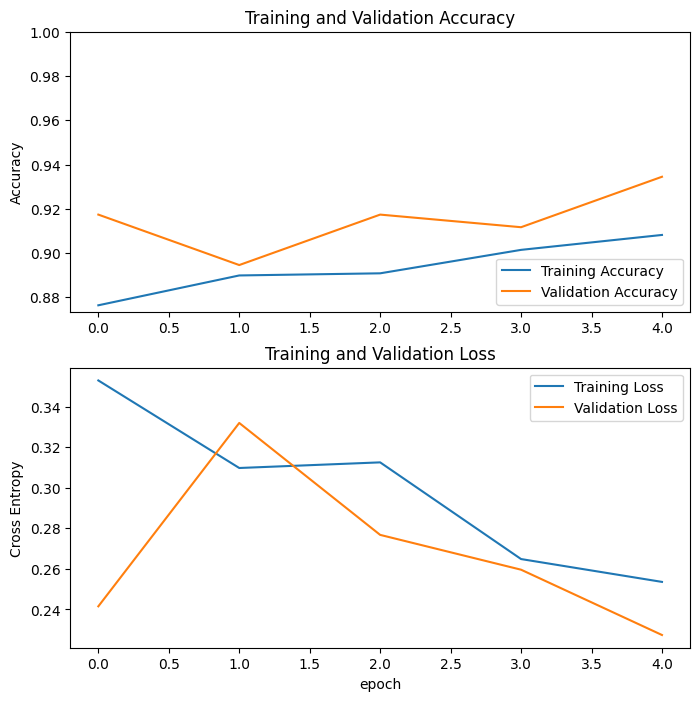

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [21]:
base_model.trainable = True


In [22]:

# Compile the model
model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(1e-5),
    metrics = ["accuracy"])
     

In [ ]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=valid_ds)

Epoch 5/10


2023-03-21 09:10:56.873309: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:10:57.531520: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:10:57.951466: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...


 1/98 [..............................] - ETA: 9:52 - loss: 0.2563 - accuracy: 0.9375

Cleanup called...


 2/98 [..............................] - ETA: 3:04 - loss: 0.2709 - accuracy: 0.9062

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:11:02.944584: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...


 3/98 [..............................] - ETA: 3:06 - loss: 0.2971 - accuracy: 0.8854

Cleanup called...
Cleanup called...
Cleanup called...


 4/98 [>.............................] - ETA: 3:08 - loss: 0.2571 - accuracy: 0.8984

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 5/98 [>.............................] - ETA: 3:04 - loss: 0.2497 - accuracy: 0.9062

Cleanup called...


 6/98 [>.............................] - ETA: 3:02 - loss: 0.2197 - accuracy: 0.9167

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 7/98 [=>............................] - ETA: 2:59 - loss: 0.2029 - accuracy: 0.9196

Cleanup called...
Cleanup called...


 8/98 [=>............................] - ETA: 2:56 - loss: 0.2078 - accuracy: 0.9180

Cleanup called...


 9/98 [=>............................] - ETA: 2:55 - loss: 0.2220 - accuracy: 0.9132

Cleanup called...
Cleanup called...


10/98 [==>...........................] - ETA: 2:53 - loss: 0.2083 - accuracy: 0.9187

Cleanup called...
2023-03-21 09:11:18.035434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-21 09:11:18.036278: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


11/98 [==>...........................] - ETA: 2:50 - loss: 0.1945 - accuracy: 0.9233

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


12/98 [==>...........................] - ETA: 2:48 - loss: 0.1860 - accuracy: 0.9297

Cleanup called...


13/98 [==>...........................] - ETA: 2:45 - loss: 0.1842 - accuracy: 0.9303

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


14/98 [===>..........................] - ETA: 2:43 - loss: 0.1868 - accuracy: 0.9286

Cleanup called...
Cleanup called...
Cleanup called...


16/98 [===>..........................] - ETA: 2:39 - loss: 0.1814 - accuracy: 0.9277

Cleanup called...


17/98 [====>.........................] - ETA: 2:37 - loss: 0.1821 - accuracy: 0.9283

Cleanup called...
Cleanup called...
2023-03-21 09:11:31.446480: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...


18/98 [====>.........................] - ETA: 2:35 - loss: 0.1815 - accuracy: 0.9288

Cleanup called...
Cleanup called...


19/98 [====>.........................] - ETA: 2:33 - loss: 0.1855 - accuracy: 0.9293

Cleanup called...
Cleanup called...


20/98 [=====>........................] - ETA: 2:31 - loss: 0.1924 - accuracy: 0.9234

Cleanup called...
Cleanup called...


21/98 [=====>........................] - ETA: 2:30 - loss: 0.1923 - accuracy: 0.9241

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


23/98 [======>.......................] - ETA: 2:25 - loss: 0.1949 - accuracy: 0.9253

Cleanup called...


24/98 [======>.......................] - ETA: 2:23 - loss: 0.1978 - accuracy: 0.9245

Cleanup called...
Cleanup called...


25/98 [======>.......................] - ETA: 2:21 - loss: 0.1919 - accuracy: 0.9275

2023-03-21 09:11:46.844272: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...


26/98 [======>.......................] - ETA: 2:19 - loss: 0.1910 - accuracy: 0.9255

Cleanup called...


27/98 [=======>......................] - ETA: 2:17 - loss: 0.1919 - accuracy: 0.9271

Cleanup called...


28/98 [=======>......................] - ETA: 2:15 - loss: 0.1907 - accuracy: 0.9286

2023-03-21 09:11:52.567404: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...


30/98 [========>.....................] - ETA: 2:11 - loss: 0.1893 - accuracy: 0.9302

Cleanup called...
Cleanup called...
Cleanup called...


31/98 [========>.....................] - ETA: 2:09 - loss: 0.1895 - accuracy: 0.9304

2023-03-21 09:11:58.336411: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-21 09:11:58.337260: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


32/98 [========>.....................] - ETA: 2:07 - loss: 0.1915 - accuracy: 0.9287

Cleanup called...
Cleanup called...
Cleanup called...


34/98 [=========>....................] - ETA: 2:04 - loss: 0.1855 - accuracy: 0.9311

Cleanup called...
Cleanup called...


35/98 [=========>....................] - ETA: 2:02 - loss: 0.1859 - accuracy: 0.9321

Cleanup called...


36/98 [==========>...................] - ETA: 2:00 - loss: 0.1865 - accuracy: 0.9314

Cleanup called...
Cleanup called...


37/98 [==========>...................] - ETA: 1:58 - loss: 0.1907 - accuracy: 0.9299

Cleanup called...
Cleanup called...
Cleanup called...


39/98 [==========>...................] - ETA: 1:54 - loss: 0.1937 - accuracy: 0.9271

Cleanup called...
Cleanup called...


40/98 [===========>..................] - ETA: 1:52 - loss: 0.1938 - accuracy: 0.9266

Cleanup called...
Cleanup called...
Cleanup called...


41/98 [===========>..................] - ETA: 1:50 - loss: 0.1917 - accuracy: 0.9268

2023-03-21 09:12:17.635133: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


42/98 [===========>..................] - ETA: 1:48 - loss: 0.1885 - accuracy: 0.9278

Cleanup called...
Cleanup called...


43/98 [============>.................] - ETA: 1:45 - loss: 0.1864 - accuracy: 0.9288

Cleanup called...


46/98 [=============>................] - ETA: 1:40 - loss: 0.1825 - accuracy: 0.9293

Cleanup called...
Cleanup called...


47/98 [=============>................] - ETA: 1:38 - loss: 0.1818 - accuracy: 0.9295

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


48/98 [=============>................] - ETA: 1:36 - loss: 0.1833 - accuracy: 0.9297

2023-03-21 09:12:30.638466: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...


50/98 [==============>...............] - ETA: 1:32 - loss: 0.1854 - accuracy: 0.9275

Cleanup called...
Cleanup called...


51/98 [==============>...............] - ETA: 1:30 - loss: 0.1840 - accuracy: 0.9283

Cleanup called...
2023-03-21 09:12:36.136193: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...


52/98 [==============>...............] - ETA: 1:28 - loss: 0.1821 - accuracy: 0.9291

Cleanup called...
Cleanup called...
Cleanup called...


53/98 [===============>..............] - ETA: 1:26 - loss: 0.1792 - accuracy: 0.9304

2023-03-21 09:12:39.937271: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...


54/98 [===============>..............] - ETA: 1:24 - loss: 0.1813 - accuracy: 0.9306

Cleanup called...
Cleanup called...
Cleanup called...


55/98 [===============>..............] - ETA: 1:22 - loss: 0.1798 - accuracy: 0.9307

Cleanup called...


56/98 [================>.............] - ETA: 1:20 - loss: 0.1811 - accuracy: 0.9308

Cleanup called...


57/98 [================>.............] - ETA: 1:18 - loss: 0.1802 - accuracy: 0.9309

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


58/98 [================>.............] - ETA: 1:16 - loss: 0.1794 - accuracy: 0.9316

Cleanup called...


59/98 [=================>............] - ETA: 1:14 - loss: 0.1786 - accuracy: 0.9317

Cleanup called...
Cleanup called...


60/98 [=================>............] - ETA: 1:12 - loss: 0.1789 - accuracy: 0.9318

Cleanup called...
Cleanup called...


61/98 [=================>............] - ETA: 1:10 - loss: 0.1805 - accuracy: 0.9314

2023-03-21 09:12:54.264513: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-21 09:12:54.336979: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...


62/98 [=================>............] - ETA: 1:08 - loss: 0.1816 - accuracy: 0.9304

Cleanup called...
Cleanup called...


65/98 [==================>...........] - ETA: 1:02 - loss: 0.1793 - accuracy: 0.9317

Cleanup called...


66/98 [===================>..........] - ETA: 1:00 - loss: 0.1787 - accuracy: 0.9323

Cleanup called...


67/98 [===================>..........] - ETA: 58s - loss: 0.1777 - accuracy: 0.9328 

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


68/98 [===================>..........] - ETA: 56s - loss: 0.1767 - accuracy: 0.9334

Cleanup called...
Cleanup called...


69/98 [====================>.........] - ETA: 55s - loss: 0.1757 - accuracy: 0.9334

Cleanup called...
Cleanup called...


70/98 [====================>.........] - ETA: 53s - loss: 0.1745 - accuracy: 0.9339

Cleanup called...


71/98 [====================>.........] - ETA: 51s - loss: 0.1758 - accuracy: 0.9327

Cleanup called...
Cleanup called...


72/98 [=====================>........] - ETA: 49s - loss: 0.1745 - accuracy: 0.9332

Cleanup called...
Cleanup called...


73/98 [=====================>........] - ETA: 47s - loss: 0.1752 - accuracy: 0.9328

Cleanup called...
2023-03-21 09:13:16.845829: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...


74/98 [=====================>........] - ETA: 45s - loss: 0.1749 - accuracy: 0.9333

Cleanup called...


75/98 [=====================>........] - ETA: 43s - loss: 0.1737 - accuracy: 0.9342

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


76/98 [======================>.......] - ETA: 41s - loss: 0.1716 - accuracy: 0.9350

2023-03-21 09:13:22.338812: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...


77/98 [======================>.......] - ETA: 39s - loss: 0.1727 - accuracy: 0.9347

Cleanup called...
2023-03-21 09:13:24.243637: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...


78/98 [======================>.......] - ETA: 37s - loss: 0.1741 - accuracy: 0.9351

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


79/98 [=======================>......] - ETA: 35s - loss: 0.1738 - accuracy: 0.9351

Cleanup called...


80/98 [=======================>......] - ETA: 34s - loss: 0.1731 - accuracy: 0.9352

Cleanup called...
Cleanup called...


81/98 [=======================>......] - ETA: 32s - loss: 0.1717 - accuracy: 0.9356

Cleanup called...
Cleanup called...


82/98 [========================>.....] - ETA: 30s - loss: 0.1702 - accuracy: 0.9364

2023-03-21 09:13:33.550782: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...


83/98 [========================>.....] - ETA: 28s - loss: 0.1701 - accuracy: 0.9367

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


84/98 [========================>.....] - ETA: 26s - loss: 0.1691 - accuracy: 0.9371

Cleanup called...
Cleanup called...
Cleanup called...


85/98 [=========================>....] - ETA: 24s - loss: 0.1700 - accuracy: 0.9375

Cleanup called...
2023-03-21 09:13:39.036950: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...


86/98 [=========================>....] - ETA: 22s - loss: 0.1687 - accuracy: 0.9379

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


87/98 [=========================>....] - ETA: 20s - loss: 0.1691 - accuracy: 0.9375

2023-03-21 09:13:42.537162: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...


98/98 [==============================] - ETA: 0s - loss: 0.1624 - accuracy: 0.9409

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:14:02.848997: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:14:03.540765: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...


98/98 [==============================] - 192s 2s/step - loss: 0.1624 - accuracy: 0.9409 - val_loss: 0.2162 - val_accuracy: 0.9288
Epoch 6/10


2023-03-21 09:14:06.373012: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:14:07.040301: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:14:07.452046: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...


 1/98 [..............................] - ETA: 4:51 - loss: 0.1114 - accuracy: 0.9688

Cleanup called...


 2/98 [..............................] - ETA: 3:10 - loss: 0.1105 - accuracy: 0.9531

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 3/98 [..............................] - ETA: 3:01 - loss: 0.1519 - accuracy: 0.9479

Cleanup called...
2023-03-21 09:14:13.336424: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...


 4/98 [>.............................] - ETA: 2:58 - loss: 0.1515 - accuracy: 0.9531

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 5/98 [>.............................] - ETA: 2:54 - loss: 0.1808 - accuracy: 0.9375

Cleanup called...


 6/98 [>.............................] - ETA: 2:52 - loss: 0.1720 - accuracy: 0.9427

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 7/98 [=>............................] - ETA: 2:49 - loss: 0.1624 - accuracy: 0.9464

Cleanup called...
Cleanup called...


 8/98 [=>............................] - ETA: 2:47 - loss: 0.1664 - accuracy: 0.9453

Cleanup called...


 9/98 [=>............................] - ETA: 2:45 - loss: 0.1834 - accuracy: 0.9340

Cleanup called...
Cleanup called...


10/98 [==>...........................] - ETA: 2:44 - loss: 0.1672 - accuracy: 0.9406

2023-03-21 09:14:26.235240: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
2023-03-21 09:14:26.241958: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


11/98 [==>...........................] - ETA: 2:42 - loss: 0.1625 - accuracy: 0.9403

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


12/98 [==>...........................] - ETA: 2:40 - loss: 0.1677 - accuracy: 0.9375

Cleanup called...


13/98 [==>...........................] - ETA: 2:37 - loss: 0.1627 - accuracy: 0.9375

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


14/98 [===>..........................] - ETA: 2:35 - loss: 0.1533 - accuracy: 0.9420

Cleanup called...
Cleanup called...
Cleanup called...


16/98 [===>..........................] - ETA: 2:31 - loss: 0.1612 - accuracy: 0.9395

Cleanup called...


17/98 [====>.........................] - ETA: 2:30 - loss: 0.1572 - accuracy: 0.9412

2023-03-21 09:14:39.065297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


18/98 [====>.........................] - ETA: 2:29 - loss: 0.1582 - accuracy: 0.9410

Cleanup called...
Cleanup called...


19/98 [====>.........................] - ETA: 2:27 - loss: 0.1565 - accuracy: 0.9424

Cleanup called...
Cleanup called...


20/98 [=====>........................] - ETA: 2:25 - loss: 0.1538 - accuracy: 0.9453

Cleanup called...
Cleanup called...


21/98 [=====>........................] - ETA: 2:22 - loss: 0.1510 - accuracy: 0.9464

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


23/98 [======>.......................] - ETA: 2:18 - loss: 0.1448 - accuracy: 0.9484

Cleanup called...


24/98 [======>.......................] - ETA: 2:16 - loss: 0.1435 - accuracy: 0.9492

Cleanup called...
Cleanup called...


25/98 [======>.......................] - ETA: 2:14 - loss: 0.1459 - accuracy: 0.9475

2023-03-21 09:14:53.736766: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...


26/98 [======>.......................] - ETA: 2:13 - loss: 0.1462 - accuracy: 0.9459

Cleanup called...


27/98 [=======>......................] - ETA: 2:10 - loss: 0.1435 - accuracy: 0.9479

Cleanup called...


28/98 [=======>......................] - ETA: 2:09 - loss: 0.1430 - accuracy: 0.9475

2023-03-21 09:14:59.238031: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...


30/98 [========>.....................] - ETA: 2:05 - loss: 0.1432 - accuracy: 0.9479

Cleanup called...
Cleanup called...
Cleanup called...


31/98 [========>.....................] - ETA: 2:03 - loss: 0.1448 - accuracy: 0.9476

2023-03-21 09:15:04.668165: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-21 09:15:04.735065: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


32/98 [========>.....................] - ETA: 2:01 - loss: 0.1483 - accuracy: 0.9482

Cleanup called...
Cleanup called...
Cleanup called...


34/98 [=========>....................] - ETA: 1:57 - loss: 0.1437 - accuracy: 0.9504

Cleanup called...
Cleanup called...


35/98 [=========>....................] - ETA: 1:56 - loss: 0.1428 - accuracy: 0.9500

Cleanup called...


36/98 [==========>...................] - ETA: 1:54 - loss: 0.1412 - accuracy: 0.9505

Cleanup called...
Cleanup called...


37/98 [==========>...................] - ETA: 1:52 - loss: 0.1411 - accuracy: 0.9502

Cleanup called...
Cleanup called...
Cleanup called...


39/98 [==========>...................] - ETA: 1:49 - loss: 0.1439 - accuracy: 0.9479

Cleanup called...
Cleanup called...


40/98 [===========>..................] - ETA: 1:47 - loss: 0.1463 - accuracy: 0.9477

Cleanup called...
Cleanup called...
Cleanup called...


41/98 [===========>..................] - ETA: 1:45 - loss: 0.1462 - accuracy: 0.9474

Cleanup called...
2023-03-21 09:15:23.535363: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...


42/98 [===========>..................] - ETA: 1:43 - loss: 0.1432 - accuracy: 0.9487

Cleanup called...
Cleanup called...


43/98 [============>.................] - ETA: 1:41 - loss: 0.1443 - accuracy: 0.9462

Cleanup called...


46/98 [=============>................] - ETA: 1:36 - loss: 0.1440 - accuracy: 0.9470

Cleanup called...
Cleanup called...


47/98 [=============>................] - ETA: 1:34 - loss: 0.1414 - accuracy: 0.9481

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


48/98 [=============>................] - ETA: 1:32 - loss: 0.1408 - accuracy: 0.9486

2023-03-21 09:15:36.438302: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...


50/98 [==============>...............] - ETA: 1:28 - loss: 0.1377 - accuracy: 0.9500

Cleanup called...
Cleanup called...


51/98 [==============>...............] - ETA: 1:26 - loss: 0.1363 - accuracy: 0.9510

2023-03-21 09:15:41.837672: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...


52/98 [==============>...............] - ETA: 1:25 - loss: 0.1380 - accuracy: 0.9501

Cleanup called...
Cleanup called...
Cleanup called...


53/98 [===============>..............] - ETA: 1:23 - loss: 0.1388 - accuracy: 0.9499

2023-03-21 09:15:45.536089: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...


54/98 [===============>..............] - ETA: 1:21 - loss: 0.1380 - accuracy: 0.9502

Cleanup called...
Cleanup called...
Cleanup called...


55/98 [===============>..............] - ETA: 1:19 - loss: 0.1383 - accuracy: 0.9494

Cleanup called...


56/98 [================>.............] - ETA: 1:17 - loss: 0.1377 - accuracy: 0.9498

Cleanup called...


57/98 [================>.............] - ETA: 1:15 - loss: 0.1367 - accuracy: 0.9501

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


58/98 [================>.............] - ETA: 1:13 - loss: 0.1372 - accuracy: 0.9499

Cleanup called...


59/98 [=================>............] - ETA: 1:11 - loss: 0.1352 - accuracy: 0.9507

Cleanup called...
Cleanup called...


60/98 [=================>............] - ETA: 1:10 - loss: 0.1353 - accuracy: 0.9510

Cleanup called...
Cleanup called...


61/98 [=================>............] - ETA: 1:08 - loss: 0.1352 - accuracy: 0.9518

2023-03-21 09:16:00.037569: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-21 09:16:00.136325: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...


62/98 [=================>............] - ETA: 1:06 - loss: 0.1340 - accuracy: 0.9526

Cleanup called...
Cleanup called...


65/98 [==================>...........] - ETA: 1:00 - loss: 0.1360 - accuracy: 0.9534

Cleanup called...


66/98 [===================>..........] - ETA: 58s - loss: 0.1359 - accuracy: 0.9536 

Cleanup called...


67/98 [===================>..........] - ETA: 57s - loss: 0.1361 - accuracy: 0.9538

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


68/98 [===================>..........] - ETA: 55s - loss: 0.1347 - accuracy: 0.9545

Cleanup called...
Cleanup called...


69/98 [====================>.........] - ETA: 53s - loss: 0.1346 - accuracy: 0.9543

Cleanup called...
Cleanup called...


70/98 [====================>.........] - ETA: 51s - loss: 0.1331 - accuracy: 0.9549

Cleanup called...


71/98 [====================>.........] - ETA: 49s - loss: 0.1330 - accuracy: 0.9551

Cleanup called...
Cleanup called...


72/98 [=====================>........] - ETA: 47s - loss: 0.1324 - accuracy: 0.9553

Cleanup called...
Cleanup called...


73/98 [=====================>........] - ETA: 46s - loss: 0.1317 - accuracy: 0.9559

Cleanup called...
2023-03-21 09:16:22.151898: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...


74/98 [=====================>........] - ETA: 44s - loss: 0.1307 - accuracy: 0.9561

Cleanup called...


75/98 [=====================>........] - ETA: 42s - loss: 0.1304 - accuracy: 0.9563

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


76/98 [======================>.......] - ETA: 40s - loss: 0.1296 - accuracy: 0.9564

2023-03-21 09:16:27.735174: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...


77/98 [======================>.......] - ETA: 38s - loss: 0.1287 - accuracy: 0.9566

2023-03-21 09:16:29.538387: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


78/98 [======================>.......] - ETA: 36s - loss: 0.1291 - accuracy: 0.9563

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


79/98 [=======================>......] - ETA: 35s - loss: 0.1279 - accuracy: 0.9569

Cleanup called...


80/98 [=======================>......] - ETA: 33s - loss: 0.1289 - accuracy: 0.9563

Cleanup called...
Cleanup called...


81/98 [=======================>......] - ETA: 31s - loss: 0.1286 - accuracy: 0.9560

Cleanup called...
Cleanup called...


82/98 [========================>.....] - ETA: 29s - loss: 0.1275 - accuracy: 0.9566

2023-03-21 09:16:38.835433: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...


83/98 [========================>.....] - ETA: 27s - loss: 0.1275 - accuracy: 0.9563

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


84/98 [========================>.....] - ETA: 25s - loss: 0.1272 - accuracy: 0.9565

Cleanup called...
Cleanup called...
Cleanup called...


85/98 [=========================>....] - ETA: 23s - loss: 0.1267 - accuracy: 0.9563

Cleanup called...
2023-03-21 09:16:44.145553: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...


86/98 [=========================>....] - ETA: 22s - loss: 0.1274 - accuracy: 0.9564

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


87/98 [=========================>....] - ETA: 20s - loss: 0.1266 - accuracy: 0.9565

2023-03-21 09:16:47.635093: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...


98/98 [==============================] - ETA: 0s - loss: 0.1227 - accuracy: 0.9589

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:17:07.258182: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:17:07.948201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...


98/98 [==============================] - 184s 2s/step - loss: 0.1227 - accuracy: 0.9589 - val_loss: 0.2131 - val_accuracy: 0.9402
Epoch 7/10


2023-03-21 09:17:10.779824: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:17:11.474803: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:17:11.946023: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...


 1/98 [..............................] - ETA: 5:01 - loss: 0.0935 - accuracy: 0.9688

Cleanup called...


 2/98 [..............................] - ETA: 3:09 - loss: 0.1153 - accuracy: 0.9531

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:17:16.449091: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...


 3/98 [..............................] - ETA: 2:59 - loss: 0.1185 - accuracy: 0.9479

Cleanup called...
Cleanup called...
Cleanup called...


 4/98 [>.............................] - ETA: 2:57 - loss: 0.1423 - accuracy: 0.9297

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 5/98 [>.............................] - ETA: 2:54 - loss: 0.1572 - accuracy: 0.9312

Cleanup called...


 6/98 [>.............................] - ETA: 2:52 - loss: 0.1436 - accuracy: 0.9427

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 7/98 [=>............................] - ETA: 2:49 - loss: 0.1368 - accuracy: 0.9464

Cleanup called...
Cleanup called...


 8/98 [=>............................] - ETA: 2:46 - loss: 0.1345 - accuracy: 0.9453

Cleanup called...


 9/98 [=>............................] - ETA: 2:45 - loss: 0.1299 - accuracy: 0.9444

Cleanup called...
Cleanup called...


10/98 [==>...........................] - ETA: 2:44 - loss: 0.1184 - accuracy: 0.9500

Cleanup called...
Cleanup called...
2023-03-21 09:17:30.742510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
2023-03-21 09:17:30.747482: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...


11/98 [==>...........................] - ETA: 2:42 - loss: 0.1166 - accuracy: 0.9517

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


12/98 [==>...........................] - ETA: 2:40 - loss: 0.1140 - accuracy: 0.9557

Cleanup called...


13/98 [==>...........................] - ETA: 2:38 - loss: 0.1153 - accuracy: 0.9567

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


14/98 [===>..........................] - ETA: 2:36 - loss: 0.1102 - accuracy: 0.9598

Cleanup called...
Cleanup called...
Cleanup called...


16/98 [===>..........................] - ETA: 2:32 - loss: 0.1162 - accuracy: 0.9551

Cleanup called...


17/98 [====>.........................] - ETA: 2:30 - loss: 0.1182 - accuracy: 0.9540

Cleanup called...
Cleanup called...
2023-03-21 09:17:43.735195: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...


18/98 [====>.........................] - ETA: 2:29 - loss: 0.1160 - accuracy: 0.9549

Cleanup called...
Cleanup called...


19/98 [====>.........................] - ETA: 2:27 - loss: 0.1177 - accuracy: 0.9556

Cleanup called...
Cleanup called...


20/98 [=====>........................] - ETA: 2:25 - loss: 0.1144 - accuracy: 0.9578

Cleanup called...
Cleanup called...


21/98 [=====>........................] - ETA: 2:23 - loss: 0.1186 - accuracy: 0.9568

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


23/98 [======>.......................] - ETA: 2:19 - loss: 0.1197 - accuracy: 0.9552

Cleanup called...


24/98 [======>.......................] - ETA: 2:17 - loss: 0.1172 - accuracy: 0.9570

Cleanup called...
Cleanup called...


25/98 [======>.......................] - ETA: 2:14 - loss: 0.1174 - accuracy: 0.9575

2023-03-21 09:17:58.343027: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...


26/98 [======>.......................] - ETA: 2:13 - loss: 0.1180 - accuracy: 0.9567

Cleanup called...


27/98 [=======>......................] - ETA: 2:11 - loss: 0.1196 - accuracy: 0.9560

Cleanup called...


28/98 [=======>......................] - ETA: 2:10 - loss: 0.1167 - accuracy: 0.9576

2023-03-21 09:18:04.144320: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...


30/98 [========>.....................] - ETA: 2:06 - loss: 0.1190 - accuracy: 0.9573

Cleanup called...
Cleanup called...
Cleanup called...


31/98 [========>.....................] - ETA: 2:04 - loss: 0.1224 - accuracy: 0.9546

Cleanup called...
2023-03-21 09:18:09.843639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-21 09:18:09.852803: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...


32/98 [========>.....................] - ETA: 2:03 - loss: 0.1240 - accuracy: 0.9541

Cleanup called...
Cleanup called...
Cleanup called...


34/98 [=========>....................] - ETA: 2:00 - loss: 0.1271 - accuracy: 0.9513

Cleanup called...
Cleanup called...


35/98 [=========>....................] - ETA: 1:58 - loss: 0.1260 - accuracy: 0.9527

Cleanup called...


36/98 [==========>...................] - ETA: 1:56 - loss: 0.1243 - accuracy: 0.9531

Cleanup called...
Cleanup called...


37/98 [==========>...................] - ETA: 1:55 - loss: 0.1287 - accuracy: 0.9519

Cleanup called...
Cleanup called...
Cleanup called...


39/98 [==========>...................] - ETA: 1:51 - loss: 0.1265 - accuracy: 0.9535

Cleanup called...
Cleanup called...


40/98 [===========>..................] - ETA: 1:49 - loss: 0.1283 - accuracy: 0.9523

Cleanup called...
Cleanup called...
Cleanup called...


41/98 [===========>..................] - ETA: 1:47 - loss: 0.1279 - accuracy: 0.9520

2023-03-21 09:18:29.636231: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


42/98 [===========>..................] - ETA: 1:45 - loss: 0.1292 - accuracy: 0.9524

Cleanup called...
Cleanup called...


43/98 [============>.................] - ETA: 1:44 - loss: 0.1288 - accuracy: 0.9520

Cleanup called...


46/98 [=============>................] - ETA: 1:38 - loss: 0.1269 - accuracy: 0.9518

Cleanup called...
Cleanup called...


47/98 [=============>................] - ETA: 1:36 - loss: 0.1259 - accuracy: 0.9528

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


48/98 [=============>................] - ETA: 1:34 - loss: 0.1263 - accuracy: 0.9525

2023-03-21 09:18:43.135629: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...


50/98 [==============>...............] - ETA: 1:30 - loss: 0.1245 - accuracy: 0.9538

Cleanup called...
Cleanup called...


51/98 [==============>...............] - ETA: 1:29 - loss: 0.1240 - accuracy: 0.9540

2023-03-21 09:18:48.644468: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...


52/98 [==============>...............] - ETA: 1:27 - loss: 0.1254 - accuracy: 0.9525

Cleanup called...
Cleanup called...
Cleanup called...


53/98 [===============>..............] - ETA: 1:25 - loss: 0.1241 - accuracy: 0.9534

2023-03-21 09:18:52.365122: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...


54/98 [===============>..............] - ETA: 1:23 - loss: 0.1236 - accuracy: 0.9537

Cleanup called...
Cleanup called...
Cleanup called...


55/98 [===============>..............] - ETA: 1:21 - loss: 0.1238 - accuracy: 0.9540

Cleanup called...


56/98 [================>.............] - ETA: 1:19 - loss: 0.1220 - accuracy: 0.9548

Cleanup called...


57/98 [================>.............] - ETA: 1:17 - loss: 0.1210 - accuracy: 0.9556

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


58/98 [================>.............] - ETA: 1:15 - loss: 0.1218 - accuracy: 0.9558

Cleanup called...


59/98 [=================>............] - ETA: 1:13 - loss: 0.1206 - accuracy: 0.9566

Cleanup called...
Cleanup called...


60/98 [=================>............] - ETA: 1:11 - loss: 0.1208 - accuracy: 0.9568

Cleanup called...
Cleanup called...


61/98 [=================>............] - ETA: 1:10 - loss: 0.1208 - accuracy: 0.9565

2023-03-21 09:19:07.941581: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-21 09:19:07.941890: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...


62/98 [=================>............] - ETA: 1:08 - loss: 0.1212 - accuracy: 0.9567

Cleanup called...
Cleanup called...


65/98 [==================>...........] - ETA: 1:03 - loss: 0.1204 - accuracy: 0.9567

Cleanup called...


66/98 [===================>..........] - ETA: 1:01 - loss: 0.1196 - accuracy: 0.9569

Cleanup called...


67/98 [===================>..........] - ETA: 59s - loss: 0.1231 - accuracy: 0.9557 

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


68/98 [===================>..........] - ETA: 57s - loss: 0.1218 - accuracy: 0.9563

Cleanup called...
Cleanup called...


69/98 [====================>.........] - ETA: 56s - loss: 0.1214 - accuracy: 0.9565

Cleanup called...
Cleanup called...


70/98 [====================>.........] - ETA: 54s - loss: 0.1219 - accuracy: 0.9558

Cleanup called...


71/98 [====================>.........] - ETA: 52s - loss: 0.1212 - accuracy: 0.9564

Cleanup called...
Cleanup called...


72/98 [=====================>........] - ETA: 50s - loss: 0.1208 - accuracy: 0.9570

Cleanup called...
Cleanup called...


73/98 [=====================>........] - ETA: 48s - loss: 0.1203 - accuracy: 0.9572

2023-03-21 09:19:34.637801: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...


74/98 [=====================>........] - ETA: 47s - loss: 0.1199 - accuracy: 0.9573

Cleanup called...


75/98 [=====================>........] - ETA: 45s - loss: 0.1193 - accuracy: 0.9575

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


76/98 [======================>.......] - ETA: 43s - loss: 0.1192 - accuracy: 0.9572

2023-03-21 09:19:41.245819: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...


77/98 [======================>.......] - ETA: 41s - loss: 0.1187 - accuracy: 0.9574

2023-03-21 09:19:43.836368: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


78/98 [======================>.......] - ETA: 39s - loss: 0.1192 - accuracy: 0.9571

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


79/98 [=======================>......] - ETA: 37s - loss: 0.1184 - accuracy: 0.9577

Cleanup called...


80/98 [=======================>......] - ETA: 35s - loss: 0.1187 - accuracy: 0.9574

Cleanup called...
Cleanup called...


81/98 [=======================>......] - ETA: 33s - loss: 0.1179 - accuracy: 0.9579

Cleanup called...
Cleanup called...


82/98 [========================>.....] - ETA: 31s - loss: 0.1170 - accuracy: 0.9585

2023-03-21 09:19:55.559034: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...


83/98 [========================>.....] - ETA: 29s - loss: 0.1173 - accuracy: 0.9582

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


84/98 [========================>.....] - ETA: 27s - loss: 0.1162 - accuracy: 0.9587

Cleanup called...
Cleanup called...
Cleanup called...


85/98 [=========================>....] - ETA: 26s - loss: 0.1150 - accuracy: 0.9592

2023-03-21 09:20:02.035176: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...


86/98 [=========================>....] - ETA: 24s - loss: 0.1145 - accuracy: 0.9597

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


87/98 [=========================>....] - ETA: 22s - loss: 0.1138 - accuracy: 0.9601

2023-03-21 09:20:06.439918: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...


98/98 [==============================] - ETA: 0s - loss: 0.1090 - accuracy: 0.9624

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:20:31.836228: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:20:32.743745: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...


98/98 [==============================] - 206s 2s/step - loss: 0.1090 - accuracy: 0.9624 - val_loss: 0.2239 - val_accuracy: 0.9345
Epoch 8/10


2023-03-21 09:20:36.682247: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:20:37.658057: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:20:38.275109: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...


 1/98 [..............................] - ETA: 6:07 - loss: 0.0989 - accuracy: 0.9688

Cleanup called...


 2/98 [..............................] - ETA: 4:00 - loss: 0.1617 - accuracy: 0.9375

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:20:43.747977: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...


 3/98 [..............................] - ETA: 3:47 - loss: 0.1689 - accuracy: 0.9062

Cleanup called...
Cleanup called...
Cleanup called...


 4/98 [>.............................] - ETA: 3:51 - loss: 0.1391 - accuracy: 0.9219

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 5/98 [>.............................] - ETA: 3:45 - loss: 0.1273 - accuracy: 0.9312

Cleanup called...


 6/98 [>.............................] - ETA: 3:37 - loss: 0.1239 - accuracy: 0.9375

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 7/98 [=>............................] - ETA: 3:39 - loss: 0.1214 - accuracy: 0.9375

Cleanup called...
Cleanup called...


 8/98 [=>............................] - ETA: 3:34 - loss: 0.1264 - accuracy: 0.9375

Cleanup called...


 9/98 [=>............................] - ETA: 3:29 - loss: 0.1185 - accuracy: 0.9444

Cleanup called...
Cleanup called...


10/98 [==>...........................] - ETA: 3:24 - loss: 0.1212 - accuracy: 0.9438

2023-03-21 09:21:01.440435: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:21:01.538391: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...
Cleanup called...


11/98 [==>...........................] - ETA: 3:20 - loss: 0.1164 - accuracy: 0.9489

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


12/98 [==>...........................] - ETA: 3:19 - loss: 0.1211 - accuracy: 0.9453

Cleanup called...


13/98 [==>...........................] - ETA: 3:14 - loss: 0.1134 - accuracy: 0.9495

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


14/98 [===>..........................] - ETA: 3:13 - loss: 0.1152 - accuracy: 0.9487

Cleanup called...
Cleanup called...
Cleanup called...


16/98 [===>..........................] - ETA: 3:06 - loss: 0.1087 - accuracy: 0.9531

Cleanup called...


17/98 [====>.........................] - ETA: 3:04 - loss: 0.1093 - accuracy: 0.9540

Cleanup called...
Cleanup called...
Cleanup called...
2023-03-21 09:21:17.247738: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...
Cleanup called...


18/98 [====>.........................] - ETA: 3:03 - loss: 0.1081 - accuracy: 0.9549

Cleanup called...
Cleanup called...


19/98 [====>.........................] - ETA: 2:59 - loss: 0.1083 - accuracy: 0.9556

Cleanup called...
Cleanup called...


20/98 [=====>........................] - ETA: 2:57 - loss: 0.1075 - accuracy: 0.9563

Cleanup called...
Cleanup called...


21/98 [=====>........................] - ETA: 2:54 - loss: 0.1155 - accuracy: 0.9539

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


23/98 [======>.......................] - ETA: 2:49 - loss: 0.1108 - accuracy: 0.9552

Cleanup called...


24/98 [======>.......................] - ETA: 2:45 - loss: 0.1100 - accuracy: 0.9557

Cleanup called...
Cleanup called...


25/98 [======>.......................] - ETA: 2:43 - loss: 0.1162 - accuracy: 0.9538

Cleanup called...
2023-03-21 09:21:34.654095: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Cleanup called...


In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# Make prediction on the validation data (not used to train on)
predictions = model.predict(valid_ds, verbose=1)

In [ ]:
predictions.shape

In [ ]:
np.sum(predictions[0])

In [ ]:
predictions[0]

In [ ]:
class_names[np.argmax(predictions[0])]

In [ ]:

class_names[np.argmax(predictions[0])]

In [ ]:

score = tf.nn.softmax(predictions[0])
score

In [ ]:
np.save('class_names.npy',class_names)

In [ ]:
model.save("flower_vegetable_detection_mobilenetv2.h5")
     

In [ ]:
model.evaluate(test_ds)

In [ ]:
  model = tf.keras.models.load_model('../../shared/fruit_veg/flower_vegetable_detection_mobilenetv2.h5')

In [ ]:
import pickle

# assume your recognition model is stored in a variable called `model`
# and you want to save it to a file called `model.pkl`
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)
